<a href="https://colab.research.google.com/github/Tony5t4rk/ML-2021-Spring/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Yang Liu

Study notes：[機器學習2021 学习笔记-Introduction](https://www.wolai.com/tony5t4rk/9d8ktj9cGJb8BUafLhWPZ9)

This program is modified based on [Sample Code](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb#scrollTo=ZeZnPAiwDRWG)。

# Show GPU

In [1]:
!nvidia-smi

Sat May 15 06:37:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Package

In [2]:
import numpy as np
import csv
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set a random seed for reproducibility
my_seed = 42096
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# Download Data from Google Drive

In [3]:
!rm -rf ./sample_data

train_file = 'covid.train.csv'
test_file = 'covid.test.csv'

if not os.path.exists(train_file):
    !gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
if not os.path.exists(test_file):
    !gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 63.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 43.1MB/s]


# Plot Utility

In [4]:
def plot_learning_curve(loss_record, title=''):
    n_epochs = len(loss_record['train'])
    x_1 = range(n_epochs)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_1, loss_record['val'], c='tab:cyan', label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig('Learning curve of {}.svg'.format(title))
    plt.show()

# Hyper-Parameters

In [5]:
os.makedirs('models', exist_ok=True)

config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'target_only': False,
    'val_ratio': 0.1,
    'reg_decay': 0.01,
    'n_epochs': 10000,
    'batch_size': 270,
    'optim_hparams': {
        'lr': 0.001,
        'momentum': 0.9
    },
    'early_stop': True,
    'early_stop_epochs': 200,
    'best_model': True,
    'model_path': 'models/model.pth',
    'pred_file': 'covid-19.pred.csv'
}

print(f'device: {config["device"]}')

device: cuda


# Data Process

## Pre-Process

In [6]:
with open(train_file, 'r') as fp:
    train_x = list(csv.reader(fp))
    train_x = np.array(train_x[1:])[:, 1:].astype(float)
with open(test_file, 'r') as fp:
    test_x = list(csv.reader(fp))
    test_x = np.array(test_x[1:])[:, 1:].astype(float)

feature_indices = (list(range(40)) + [57, 75]) if config['target_only'] else list(range(40)) + [40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]

train_x, train_y = train_x[:, feature_indices], train_x[:, -1]
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=config['val_ratio'], random_state=my_seed)
test_x = test_x[:, feature_indices]

## Dataset

In [7]:
class COVID19_Dataset(Dataset):
    def __init__(self, x, y=None, mean=None, std=None):
        self.data = torch.from_numpy(x).float()
        if mean is None and std is None:
            self.mean = self.data[:, 40:].mean(dim=0, keepdim=True)
            self.std = self.data[:, 40:].std(dim=0, keepdim=True)
        else:
            self.mean = mean
            self.std = std
        self.data[:, 40:] = (self.data[:, 40:] - self.mean) / self.std
        if y is not None:
            self.label = torch.from_numpy(y).float()
        else:
            self.label = None
        self.dim = self.data.shape[1]
    
    def __getitem__(self, index):
        if self.label is not None:
            return self.data[index], self.label[index]
        else:
            return self.data[index]
    
    def __len__(self):
        return len(self.data)

train_dataset = COVID19_Dataset(train_x, train_y)
val_dataset = COVID19_Dataset(val_x, val_y, train_dataset.mean, train_dataset.std)
test_dataset = COVID19_Dataset(test_x, None, train_dataset.mean, train_dataset.std)

print(f'Train Dataset: {len(train_dataset)} samples')
print(f'Valid Dataset: {len(val_dataset)} samples')
print(f'Test Dataset: {len(test_dataset)} samples')

Train Dataset: 2430 samples
Valid Dataset: 270 samples
Test Dataset: 893 samples


## DataLoader

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# Model

In [9]:
class Net(nn.Module):
    def __init__(self, in_dim):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(in_dim, 74),
            nn.ReLU(),
            nn.Linear(74, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(1)

model = Net(train_dataset.dim).to(config['device'])

# Training

In [10]:
# L1 > L2 > None
def calc_regularization(model, p=1):
    reg_loss = 0
    if p == 1:
        for name, param in model.named_parameters():
            if 'weight' in name:
                reg_loss += config['reg_decay'] * torch.sum(torch.abs(param))
    elif p == 2:
        for name, param in model.named_parameters():
            if 'weight' in name:
                reg_loss += config['reg_decay'] * torch.norm(param, p=2)
    else:
        pass
    return reg_loss

def calc_loss(model, criterion, pred, label, p=1, eps=1e-6):
    # RMSE + Regularization
    return torch.sqrt(criterion(pred, label) + eps) + calc_regularization(model, p=p)

In [11]:
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), **config['optim_hparams'])

In [12]:
loss_record = {'train': [], 'val': []}

if config['early_stop']:
    early_stop_cnt = 0

min_val_loss = float('inf')

epoch = 0
while epoch < config['n_epochs']:
    model.train()
    train_loss = []
    for x, y in train_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        optimizer.zero_grad()
        pred = model(x)
        loss = calc_loss(model, criterion, pred, y, p=1)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = sum(train_loss) / len(train_loss)
    loss_record['train'].append(train_loss)

    model.eval()
    val_loss = []
    for x, y in val_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        with torch.no_grad():
            pred = model(x)
        loss = calc_loss(model, criterion, pred, y, p=1)
        val_loss.append(loss.item())
    val_loss = sum(val_loss) / len(val_loss)
    loss_record['val'].append(val_loss)

    if config['best_model']:
        if val_loss < min_val_loss:
            torch.save(model, config['model_path'])
    else:
        torch.save(model, config['model_path'])
    
    print(f'[ Epoch {epoch + 1:03d}/{config["n_epochs"]:03d} ] Train Loss: {train_loss:.5f} Valid Loss: {val_loss:.5f}')

    if config['early_stop']:
        if val_loss < min_val_loss:
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
    
    epoch += 1
    if val_loss < min_val_loss:
        min_val_loss = val_loss

    if config['early_stop'] and early_stop_cnt > config['early_stop_epochs']:
        break

print(f'Finish Train After {epoch} Epochs')

流式输出内容被截断，只能显示最后 5000 行内容。
[ Epoch 652/10000 ] Train Loss: 1.19639 Valid Loss: 1.12600
[ Epoch 653/10000 ] Train Loss: 1.18899 Valid Loss: 1.12445
[ Epoch 654/10000 ] Train Loss: 1.18891 Valid Loss: 1.12514
[ Epoch 655/10000 ] Train Loss: 1.18894 Valid Loss: 1.12364
[ Epoch 656/10000 ] Train Loss: 1.18730 Valid Loss: 1.12412
[ Epoch 657/10000 ] Train Loss: 1.19072 Valid Loss: 1.12359
[ Epoch 658/10000 ] Train Loss: 1.18910 Valid Loss: 1.12420
[ Epoch 659/10000 ] Train Loss: 1.19052 Valid Loss: 1.12692
[ Epoch 660/10000 ] Train Loss: 1.18783 Valid Loss: 1.12393
[ Epoch 661/10000 ] Train Loss: 1.19028 Valid Loss: 1.12407
[ Epoch 662/10000 ] Train Loss: 1.18818 Valid Loss: 1.12287
[ Epoch 663/10000 ] Train Loss: 1.18676 Valid Loss: 1.12467
[ Epoch 664/10000 ] Train Loss: 1.18800 Valid Loss: 1.12288
[ Epoch 665/10000 ] Train Loss: 1.18819 Valid Loss: 1.12271
[ Epoch 666/10000 ] Train Loss: 1.18808 Valid Loss: 1.12357
[ Epoch 667/10000 ] Train Loss: 1.18938 Valid Loss: 1.12398
[ Epoch 668/1

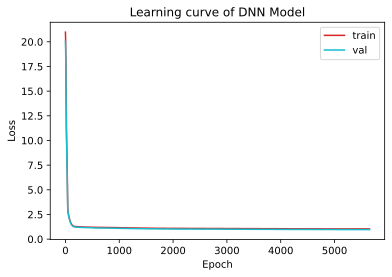

In [13]:
plot_learning_curve(loss_record, title='DNN Model')

# Testing

In [14]:
if config['best_model']:
    del model
    model = torch.load(config['model_path']).to(config['device'])

In [15]:
model.eval()
preds = []
for x in test_dataloader:
    x = x.to(config['device'])
    with torch.no_grad():
        pred = model(x)
    preds.append(pred.detach().cpu())
preds = torch.cat(preds, dim=0).numpy()

In [16]:
print(f'Saving Result to {config["pred_file"]}')

with open(config['pred_file'], 'w') as fp:
    fp.write('id,tested_positive\n')
    for id, pred in enumerate(preds):
        fp.write(f'{id},{pred}\n')

Saving Result to covid-19.pred.csv


In [17]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./models '/content/drive/MyDrive/Colab/ML 2021 Spring/HW01/'
!cp ./*.pred.csv '/content/drive/MyDrive/Colab/ML 2021 Spring/HW01/'
!cp ./*.svg '/content/drive/MyDrive/Colab/ML 2021 Spring/HW01/'

Mounted at /content/drive


# Result

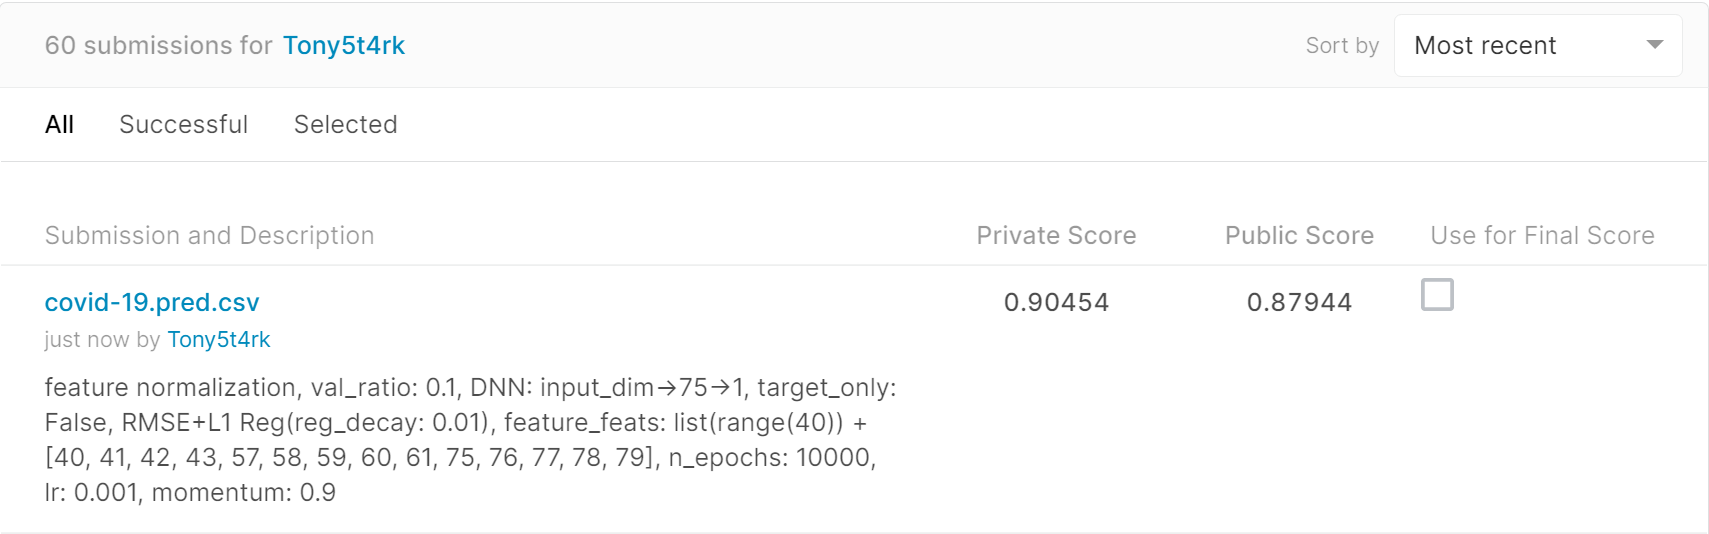